In [3]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "2JOF"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"

# Visualization

In [4]:
# PDB

pdb_traj = md.load_pdb(pdb_path)
pdb_view = nv.show_mdtraj(
    pdb_traj,
    height="400px",
    width="400px"
)
pdb_view.add_representation("licorice", selection="protein")

print(pdb_traj)
pdb_view

<mdtraj.Trajectory with 1 frames, 272 atoms, 20 residues, without unitcells>


NGLWidget()

In [5]:
ca_atoms = [atom for atom in pdb_traj.topology.atoms if atom.name == "CA"]

# Extract their indices
ca_indices = [atom.index for atom in ca_atoms]

print("Alpha carbon indices:", ca_indices)
cnt = 1
for i in range(len(ca_indices)):
    for j in range(i+1, len(ca_indices)):
        print(f"d{cnt}: DISTANCE ATOMS={ca_indices[i]+1},{ca_indices[j]+1}")
        cnt += 1

print("ARG=" + ",".join(f"d{i+1}" for i in range(cnt)))

Alpha carbon indices: [1, 15, 25, 46, 56, 73, 97, 116, 126, 138, 145, 152, 166, 177, 188, 195, 219, 233, 247, 261]
d1: DISTANCE ATOMS=2,16
d2: DISTANCE ATOMS=2,26
d3: DISTANCE ATOMS=2,47
d4: DISTANCE ATOMS=2,57
d5: DISTANCE ATOMS=2,74
d6: DISTANCE ATOMS=2,98
d7: DISTANCE ATOMS=2,117
d8: DISTANCE ATOMS=2,127
d9: DISTANCE ATOMS=2,139
d10: DISTANCE ATOMS=2,146
d11: DISTANCE ATOMS=2,153
d12: DISTANCE ATOMS=2,167
d13: DISTANCE ATOMS=2,178
d14: DISTANCE ATOMS=2,189
d15: DISTANCE ATOMS=2,196
d16: DISTANCE ATOMS=2,220
d17: DISTANCE ATOMS=2,234
d18: DISTANCE ATOMS=2,248
d19: DISTANCE ATOMS=2,262
d20: DISTANCE ATOMS=16,26
d21: DISTANCE ATOMS=16,47
d22: DISTANCE ATOMS=16,57
d23: DISTANCE ATOMS=16,74
d24: DISTANCE ATOMS=16,98
d25: DISTANCE ATOMS=16,117
d26: DISTANCE ATOMS=16,127
d27: DISTANCE ATOMS=16,139
d28: DISTANCE ATOMS=16,146
d29: DISTANCE ATOMS=16,153
d30: DISTANCE ATOMS=16,167
d31: DISTANCE ATOMS=16,178
d32: DISTANCE ATOMS=16,189
d33: DISTANCE ATOMS=16,196
d34: DISTANCE ATOMS=16,220
d35: D

In [3]:
# Count the number of .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)

print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

# Extract the indices from filenames and sort them
file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    # Extract the index from filename like "2JOF-0-protein-000.dcd"
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 105 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-*.dcd
File indices range: 0 to 104
Total files to load: 105


In [4]:
# Load trajectories using the actual file indices found
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    # print(file_path)
    # Check if file exists before loading
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Successfully loaded {len(traj_list)} trajectory files")
all_traj = md.join(traj_list)

Loading trajectories: 100%|██████████| 105/105 [00:03<00:00, 29.27it/s]


Successfully loaded 105 trajectory files


In [5]:
view = nv.show_mdtraj(
    all_traj,
	height="400px",
    width="400px"
)
view.add_representation("licorice", selection="protein")
print(f"Total frames: {all_traj.n_frames}")
view

Total frames: 1044000


NGLWidget(max_frame=1043999)

In [6]:
view.frame = 24623

# Descriptors

In [7]:
pdb = md.load(pdb_path)
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb.topology.residues), 2)]
)
ca_pair_contacts, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())

# torch.save(
#     torch.from_numpy(ca_pair_contacts),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad.pt"
# )

(1044000, 190)
1.1409878


In [8]:
exp = 2
ca_pair_distances_swtich = (1 - (np.power(ca_pair_contacts, exp) / 0.8)) / (1 - (np.power(ca_pair_contacts, exp) / 0.8))
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())

# torch.save(
#     torch.from_numpy(ca_pair_distances_swtich),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-cad-switch.pt"
# )

(1044000, 190)
1.0


In [9]:
xyz = all_traj.xyz
print(xyz.shape)

# torch.save(
#     torch.from_numpy(xyz),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos.pt"
# )

(1044000, 272, 3)


# TICA

In [34]:
def cad2switch(
    cad,
    cutoff: float = 0.8
) -> np.ndarray:
	if type(cad) == torch.Tensor:
		cad = cad.numpy()
	return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))

In [ ]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)

for lag in (1, 5, 10, 100, 200, 400, 1000):
	data = ca_pair_contacts
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

In [40]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)
pdb_state_ca_pair_distances = cad2switch(pdb_state_ca_pair_distances)
data_switch = cad2switch(ca_pair_contacts)

for lag in (10, 100, 200):
	tica_obj = pyemma.coordinates.tica(data_switch, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

/tmp/ipykernel_830079/1269659341.py:7: RuntimeWarning: invalid value encountered in divide
  return (1 - np.power(cad / cutoff, 6)) / (1 - np.power(cad / cutoff, 12))
/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

InvalidDataInStreamException: Found invalid values in chunk in trajectory index 0 at chunk [353214, 706418] within frames (array([216458]), array([18])).

# Analysis

## States by RMSD

In [10]:
def rmsd_to_refpdb(
	traj: md.Trajectory,
	reference_traj: md.Trajectory,
	atom_type: str = "ca",
) -> np.ndarray:
	"""
	Generate binary labels for folded/unfolded states based on RMSD
	"""
	if atom_type == "ca":
		atom_indices = traj.topology.select("name CA")
	else:
		atom_indices = None
	
	rmsd = md.rmsd(
		target = traj,
		reference = reference_traj,
		atom_indices = atom_indices
	)
	return rmsd

### Folded

In [18]:
ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/notebook/{molecule}_from_mae.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
rmsd = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = ref_pdb_traj,
)

print(rmsd.mean())
plt.hist(
    rmsd,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/shpark/prj-mlcv/lib/DESRES/notebook/2JOF_from_mae.pdb'

In [ ]:
print(all_traj)
print(rmsd.shape)

# torch.save(
#     torch.from_numpy(rmsd),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-rmsd.pt"
# )
# torch.save(
#     torch.from_numpy(rmsd < 0.3),
#     f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-label-rmsd-folded.pt"
# )

<mdtraj.Trajectory with 1044000 frames, 272 atoms, 20 residues, and unitcells>
(1044000,)


In [34]:
# TICA with pair distances

pdb_state = md.load(pdb_path)
lag = 10
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb_state.topology.residues), 2)]
)
data, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
tica_data = tica_obj.get_output()[0]
x = tica_data[:, 0]
y = tica_data[:, 1]

pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)
pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
pdb_tica_x = pdb_tica_data[:, 0]
pdb_tica_y = pdb_tica_data[:, 1]

/home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

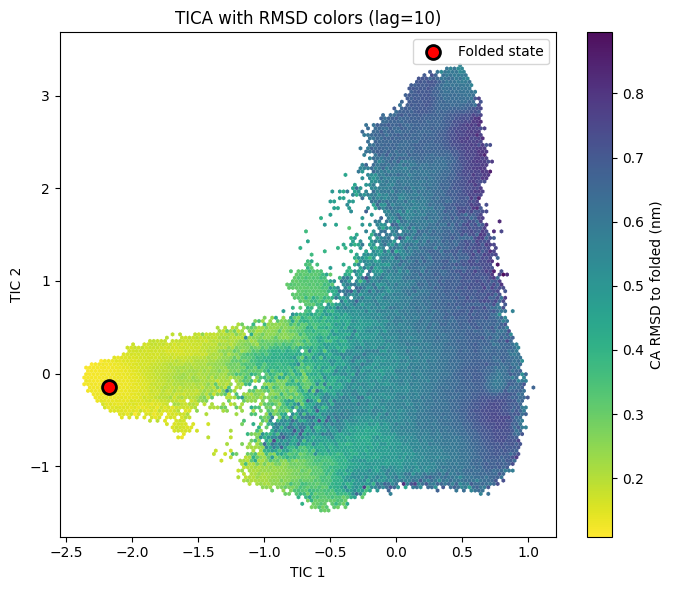

In [35]:
# Plot TICA with RMSD colors
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
sc = ax.hexbin(
	x, y,
	C=rmsd,
	gridsize=120,
	cmap='viridis_r',
	reduce_C_function=np.mean,
 	mincnt=3,
  	linewidths=0,
  	edgecolors="none",
   	alpha=0.95,
)
ax.scatter(
    pdb_tica_x,
    pdb_tica_y,
    c="red",
    s=100,
    edgecolors="k",
    linewidths=2,
    label="Folded state",
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with RMSD colors (lag={lag})")
ax.legend(loc="best")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("CA RMSD to folded (nm)")
plt.tight_layout()
plt.show()
plt.close()

In [40]:
torch.save(torch.from_numpy(rmsd), f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt")
# torch.save(torch.from_numpy(label_by_rmsd), f"{save_dir}/{molecule}-{simulation_idx}-label_rmsd.pt")

### Unfolded

In [11]:
rmsd_loaded = torch.load( f"{save_dir}/{molecule}-{simulation_idx}-rmsd.pt").numpy()
rmsd_max_frame_idx = np.argmax(rmsd_loaded)
rmsd_max_frame = all_traj[rmsd_max_frame_idx]
rmsd_view = nv.show_mdtraj(rmsd_max_frame)
rmsd_view.add_representation("licorice", selection="protein")
rmsd_view

NGLWidget()

In [12]:
ref_pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/folded.pdb"
ref_pdb_traj = md.load_pdb(ref_pdb_path)
atom_indices = all_traj.topology.select("name CA")

max_rmsd = md.rmsd(
	target = rmsd_max_frame,
	reference = ref_pdb_traj,
	atom_indices = atom_indices
)
print(max_rmsd)

[1.5235872]


In [ ]:
# save_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/unfolded.pdb"
# rmsd_max_frame.save_pdb(save_path)

(1044000,)
1.3113079


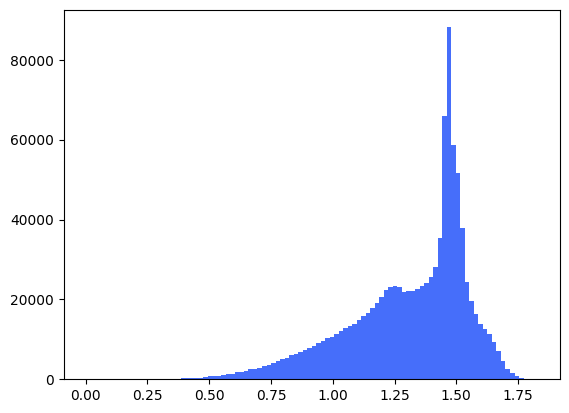

In [13]:
unfolded_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/unfolded.pdb"
unfolded_traj = md.load_pdb(unfolded_path)
rmsd_to_unfolded = rmsd_to_refpdb(
    traj = all_traj,
    reference_traj = unfolded_traj,
)

print(rmsd_to_unfolded.shape)
print(rmsd_to_unfolded.mean())
plt.hist(
    rmsd_to_unfolded,
    bins=100,
    # log=True,
    color=blue,
)
plt.show()


In [14]:
torch.save(torch.from_numpy(rmsd_to_unfolded), f"{save_dir}/{molecule}-{simulation_idx}-rmsd_unfolded.pt")

## Secondary structure

In [21]:
dssp_all = md.compute_dssp(
    all_traj,
    simplified=False
)
print(dssp_all.shape)
print(dssp_all[0])
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp.npy"
np.save(dssp_path, dssp_all)

(1044000, 20)
[' ' ' ' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T' 'H' 'H' 'H' 'H' 'T' ' ' ' ' ' '
 ' ' ' ']


In [20]:
dssp_all = md.compute_dssp(
    all_traj,
    simplified=True
)
print(dssp_all.shape)
print(dssp_all[0])
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-simplified.npy"
np.save(dssp_path, dssp_all)

(1044000, 20)
['C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'C' 'C' 'H' 'H' 'H' 'H' 'C' 'C' 'C' 'C'
 'C' 'C']


In [12]:
dssp_loaded = np.load(dssp_path)
print(dssp_loaded.shape)

(1044000, 20)


In [19]:
dssp_helix = np.array([True if "H" or "G" or "I" in dssp else False for dssp in dssp_all])
print(dssp_helix.shape)
print(dssp_helix[0])

np.save(
    f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-helix.npy",
    dssp_helix
)

(1044000,)
True


In [28]:
# Plot TICA with helix colors
pdb_state = md.load(pdb_path)
lag = 10
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(pdb_state.topology.residues), 2)]
)
data, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
tica_data = tica_obj.get_output()[0]
x = tica_data[:, 0]
y = tica_data[:, 1]
# helix_color = np.array(["red" if dssp else "blue" for dssp in dssp_all])

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_830079/2145005465.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


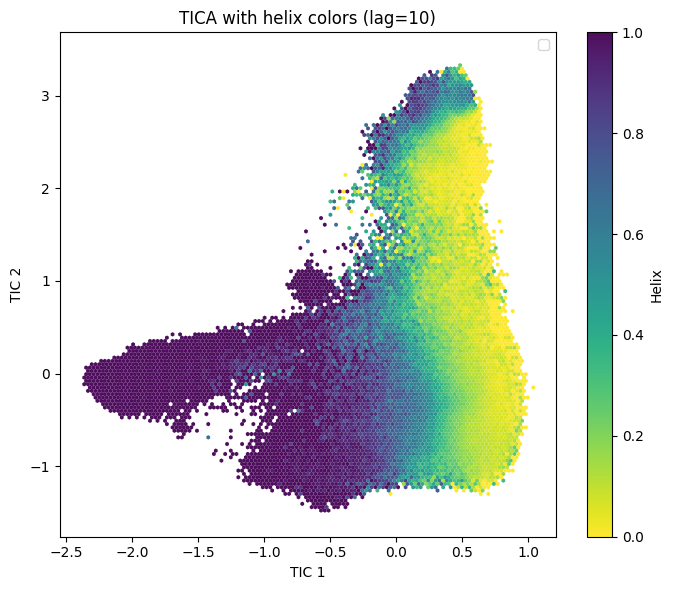

In [30]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
sc = ax.hexbin(
	x, y,
	C=dssp_helix,
	gridsize=120,
	cmap='viridis_r',
	reduce_C_function=np.mean,
 	mincnt=3,
  	linewidths=0,
  	edgecolors="none",
   	alpha=0.95,
)
ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_title(f"TICA with helix colors (lag={lag})")
ax.legend(loc="best")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("Helix")
plt.tight_layout()
plt.show()
plt.close()

In [26]:
# Create density scatter plot: residue number vs CV value
# Using DSSP data to analyze secondary structure distribution

# First, let's understand the DSSP data structure
print("DSSP data shape:", dssp_all.shape)
print("Number of frames:", dssp_all.shape[0])
print("Number of residues:", dssp_all.shape[1])
print("Sample DSSP data (first frame):", dssp_all[0])

# Convert DSSP labels to numerical values for plotting
# H = Helix, E = Beta sheet, C = Coil/Loop
dssp_to_num = {'H': 1, 'E': 2, 'C': 0}

# Create arrays for plotting
residue_numbers = []
cv_values = []

# Process each frame
for frame_idx in range(dssp_all.shape[0]):
    for residue_idx in range(dssp_all.shape[1]):
        residue_num = residue_idx + 1  # 1-indexed residue numbers
        dssp_label = dssp_all[frame_idx, residue_idx]
        cv_value = dssp_to_num.get(dssp_label, 0)  # Default to 0 for unknown labels
        
        residue_numbers.append(residue_num)
        cv_values.append(cv_value)

residue_numbers = np.array(residue_numbers)
cv_values = np.array(cv_values)

print(f"Total data points: {len(residue_numbers)}")
print(f"Residue range: {residue_numbers.min()} - {residue_numbers.max()}")
print(f"CV value range: {cv_values.min()} - {cv_values.max()}")


DSSP data shape: (1044000, 20)
Number of frames: 1044000
Number of residues: 20
Sample DSSP data (first frame): [' ' ' ' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T' 'H' 'H' 'H' 'H' 'T' ' ' ' ' ' '
 ' ' ' ']
Total data points: 20880000
Residue range: 1 - 20
CV value range: 0 - 2


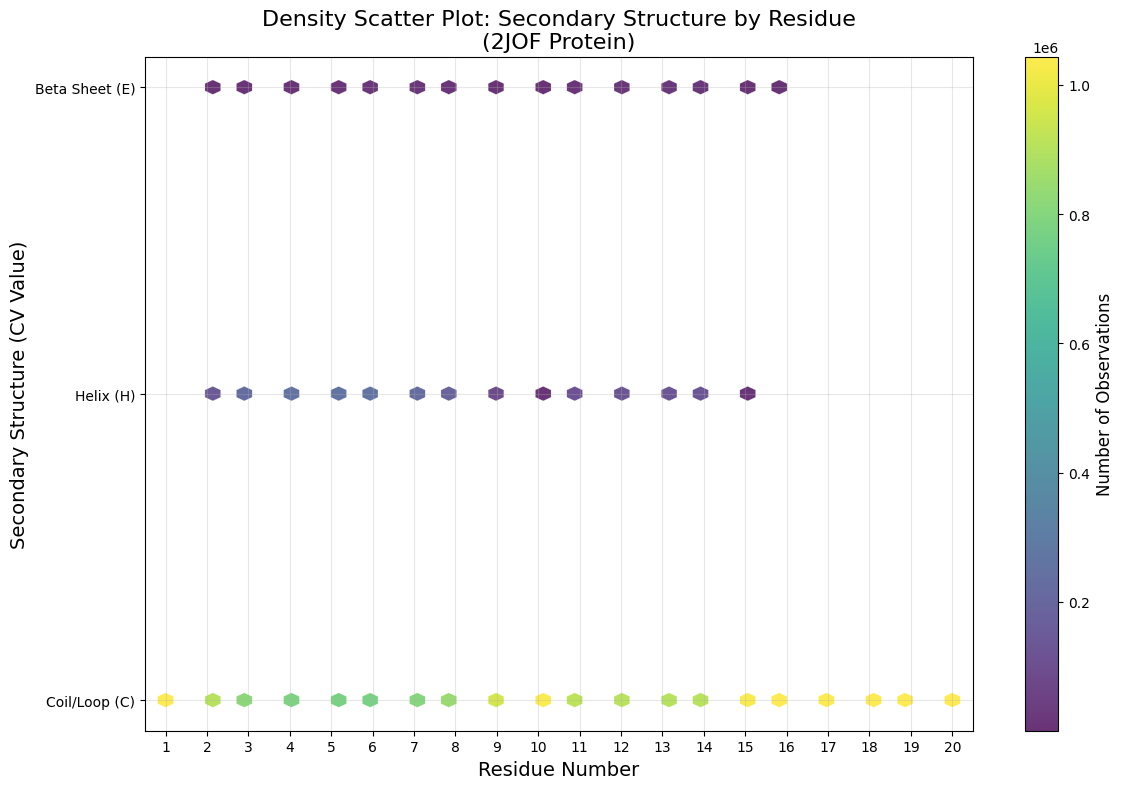


Summary Statistics:
Residue  1: Helix=  0.0%, Sheet=  0.0%, Coil=100.0%
Residue  2: Helix= 13.5%, Sheet=  0.1%, Coil= 86.5%
Residue  3: Helix= 21.6%, Sheet=  0.4%, Coil= 78.0%
Residue  4: Helix= 24.4%, Sheet=  0.7%, Coil= 75.0%
Residue  5: Helix= 24.9%, Sheet=  1.0%, Coil= 74.1%
Residue  6: Helix= 24.5%, Sheet=  1.4%, Coil= 74.1%
Residue  7: Helix= 22.0%, Sheet=  1.4%, Coil= 76.6%
Residue  8: Helix= 18.0%, Sheet=  1.0%, Coil= 81.0%
Residue  9: Helix=  8.4%, Sheet=  0.0%, Coil= 91.6%
Residue 10: Helix=  0.6%, Sheet=  0.0%, Coil= 99.4%
Residue 11: Helix= 11.2%, Sheet=  1.2%, Coil= 87.6%
Residue 12: Helix= 11.8%, Sheet=  1.3%, Coil= 86.9%
Residue 13: Helix= 11.8%, Sheet=  1.6%, Coil= 86.6%
Residue 14: Helix= 11.8%, Sheet=  1.3%, Coil= 86.9%
Residue 15: Helix=  0.6%, Sheet=  0.3%, Coil= 99.1%
Residue 16: Helix=  0.0%, Sheet=  0.2%, Coil= 99.8%
Residue 17: Helix=  0.0%, Sheet=  0.0%, Coil=100.0%
Residue 18: Helix=  0.0%, Sheet=  0.0%, Coil=100.0%
Residue 19: Helix=  0.0%, Sheet=  0.0%, Coi

In [31]:
# Create the density scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Use hexbin for density visualization
hb = ax.hexbin(residue_numbers, cv_values, 
               gridsize=50, 
               cmap='viridis', 
               mincnt=1,
               linewidths=0.2,
               edgecolors='white',
               alpha=0.8)

# Customize the plot
ax.set_xlabel('Residue Number', fontsize=14)
ax.set_ylabel('Secondary Structure (CV Value)', fontsize=14)
ax.set_title('Density Scatter Plot: Secondary Structure by Residue\n(2JOF Protein)', fontsize=16)

# Set y-axis labels for secondary structure types
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Coil/Loop (C)', 'Helix (H)', 'Beta Sheet (E)'])

# Set x-axis to show all residues
ax.set_xlim(0.5, 20.5)
ax.set_xticks(range(1, 21))

# Add colorbar
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Number of Observations', fontsize=12)

# Add grid for better readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for residue in range(1, 21):
    mask = residue_numbers == residue
    residue_data = cv_values[mask]
    
    helix_pct = (residue_data == 1).mean() * 100
    sheet_pct = (residue_data == 2).mean() * 100
    coil_pct = (residue_data == 0).mean() * 100
    
    print(f"Residue {residue:2d}: Helix={helix_pct:5.1f}%, Sheet={sheet_pct:5.1f}%, Coil={coil_pct:5.1f}%")


In [32]:
# Alternative visualization: Discrete scatter plot with jittering
fig, ax = plt.subplots(figsize=(14, 8))

# Add small random jitter to y-values for better visibility
np.random.seed(42)  # For reproducibility
jitter_amount = 0.1
cv_values_jittered = cv_values + np.random.uniform(-jitter_amount, jitter_amount, len(cv_values))

# Create scatter plot with alpha for density visualization
scatter = ax.scatter(residue_numbers, cv_values_jittered, 
                    alpha=0.01, 
                    s=1, 
                    c=cv_values, 
                    cmap='Set1',
                    rasterized=True)

# Customize the plot
ax.set_xlabel('Residue Number', fontsize=14)
ax.set_ylabel('Secondary Structure (CV Value)', fontsize=14)
ax.set_title('Discrete Scatter Plot: Secondary Structure Distribution by Residue\n(2JOF Protein - All Frames)', fontsize=16)

# Set y-axis labels for secondary structure types
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Coil/Loop (C)', 'Helix (H)', 'Beta Sheet (E)'])

# Set x-axis to show all residues
ax.set_xlim(0.5, 20.5)
ax.set_xticks(range(1, 21))
ax.set_ylim(-0.5, 2.5)

# Add horizontal lines to separate secondary structure types
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=1.5, color='gray', linestyle='--', alpha=0.5)

# Add grid for better readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


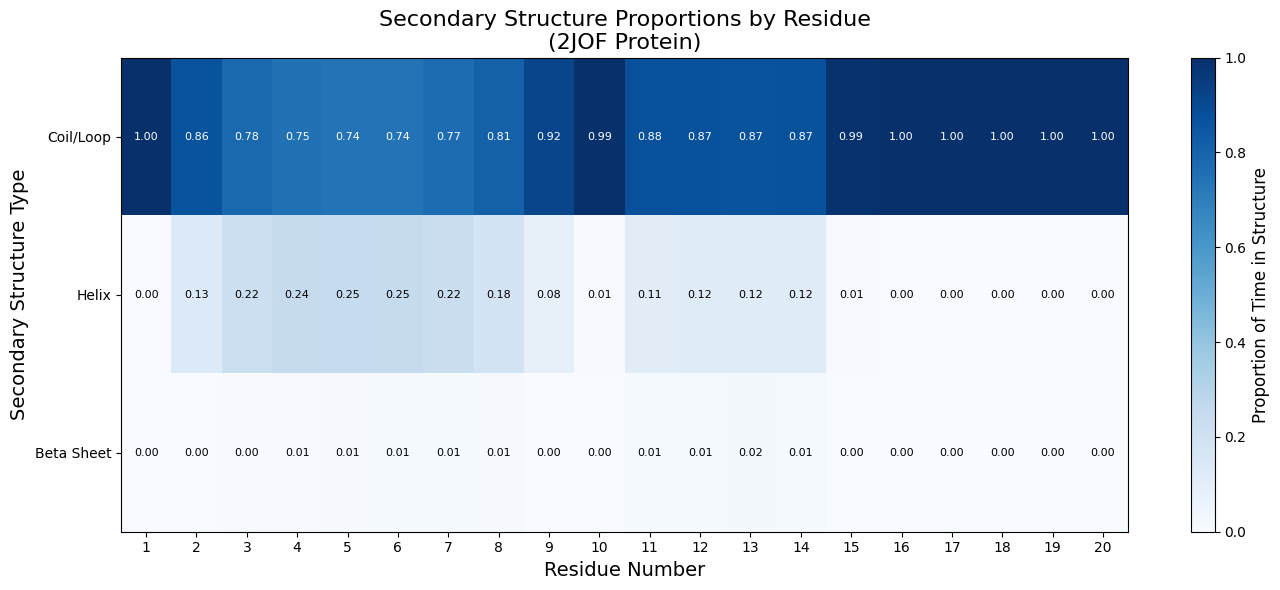


Most common secondary structure per residue:
Residue  1: Coil/Loop    (100.0%)
Residue  2: Coil/Loop    (86.5%)
Residue  3: Coil/Loop    (78.0%)
Residue  4: Coil/Loop    (75.0%)
Residue  5: Coil/Loop    (74.1%)
Residue  6: Coil/Loop    (74.1%)
Residue  7: Coil/Loop    (76.6%)
Residue  8: Coil/Loop    (81.0%)
Residue  9: Coil/Loop    (91.6%)
Residue 10: Coil/Loop    (99.4%)
Residue 11: Coil/Loop    (87.6%)
Residue 12: Coil/Loop    (86.9%)
Residue 13: Coil/Loop    (86.6%)
Residue 14: Coil/Loop    (86.9%)
Residue 15: Coil/Loop    (99.1%)
Residue 16: Coil/Loop    (99.8%)
Residue 17: Coil/Loop    (100.0%)
Residue 18: Coil/Loop    (100.0%)
Residue 19: Coil/Loop    (100.0%)
Residue 20: Coil/Loop    (100.0%)


In [33]:
# Create a heatmap-style visualization for better density representation
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate the frequency of each secondary structure type for each residue
residue_range = range(1, 21)
ss_types = [0, 1, 2]  # Coil, Helix, Sheet
ss_labels = ['Coil/Loop', 'Helix', 'Beta Sheet']

# Create frequency matrix
freq_matrix = np.zeros((len(ss_types), len(residue_range)))

for i, ss_type in enumerate(ss_types):
    for j, residue in enumerate(residue_range):
        mask = (residue_numbers == residue) & (cv_values == ss_type)
        freq_matrix[i, j] = mask.sum()

# Normalize by total observations per residue to get proportions
total_per_residue = freq_matrix.sum(axis=0)
prop_matrix = freq_matrix / total_per_residue[np.newaxis, :]

# Create the heatmap
im = ax.imshow(prop_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=1)

# Customize the plot
ax.set_xlabel('Residue Number', fontsize=14)
ax.set_ylabel('Secondary Structure Type', fontsize=14)
ax.set_title('Secondary Structure Proportions by Residue\n(2JOF Protein)', fontsize=16)

# Set ticks and labels
ax.set_xticks(range(len(residue_range)))
ax.set_xticklabels(residue_range)
ax.set_yticks(range(len(ss_labels)))
ax.set_yticklabels(ss_labels)

# Add text annotations showing percentages
for i in range(len(ss_types)):
    for j in range(len(residue_range)):
        text = ax.text(j, i, f'{prop_matrix[i, j]:.2f}',
                      ha="center", va="center", color="white" if prop_matrix[i, j] > 0.5 else "black",
                      fontsize=8)

# Add colorbar
cb = plt.colorbar(im, ax=ax)
cb.set_label('Proportion of Time in Structure', fontsize=12)

plt.tight_layout()
plt.show()

# Print the most common secondary structure for each residue
print("\nMost common secondary structure per residue:")
for j, residue in enumerate(residue_range):
    max_idx = np.argmax(prop_matrix[:, j])
    max_prop = prop_matrix[max_idx, j]
    print(f"Residue {residue:2d}: {ss_labels[max_idx]:12s} ({max_prop:.1%})")


# Conclusion